In [10]:
from siml.sk_utils import *
from siml.signal_analysis_utils import *
import numpy as np
import matplotlib.pyplot as plt
import warnings
import pywt
import heapq
from collections import defaultdict, Counter

from detecta import detect_peaks
from scipy.fftpack import fft
from scipy.signal import welch


## 加载数据文件

In [11]:
typeDescription = {
    0: 'normal',
    1: 'pothole',
    2: 'transverse',
}


def readFile(filename):
    return np.loadtxt(filename)

In [12]:
folderPath = '../../data/Final_Version/all/datasets/'
dataFile = ['dataX.txt', 'dataY.txt', 'dataZ.txt']
labelFile = ['dataLabel.txt']

signals = []
for file in dataFile:
    dataPath = folderPath+file
    signals.append(np.loadtxt(dataPath))
signals = np.transpose(np.array(signals), (1, 2, 0))
print('数据集：', signals.shape)

labelFilePath = folderPath+labelFile[0]
dataLabel = np.loadtxt(labelFilePath)
anomalyType = list(dataLabel[:, 0])

dic = {}
temp = Counter(anomalyType)
for key in temp.keys():
    dic[typeDescription[key]] = temp[key]
print(dic)

数据集： (4088, 64, 3)
{'normal': 3601, 'pothole': 474, 'transverse': 13}


## 选择一个pothole样本

In [13]:
N = 64 #样本数
f_s = 50 #采样频率
denominator = 10

In [14]:
# 选择一个信号样本（signal为长度128的列表*3）
signal_no = 2184
signal = signals[signal_no, :, :]
signal = signal[:, 2]
label = anomalyType[signal_no]
roadType = typeDescription[label]
print(roadType)

pothole


## 频域

In [15]:
#时域
def get_values(y_values, N, f_s):
    f_values = np.linspace(0.0, N/f_s, N)
    return f_values, y_values

#FFT
def get_fft_values(y_values, N, f_s):
    f_values = np.linspace(0.0, f_s/2.0, N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values

#PSD
def get_psd_values(y_values, N, f_s):
    f_values, psd_values = welch(y_values, fs=f_s)
    return f_values, psd_values

#Autocorrelation
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[len(result)//2:]
 
def get_autocorr_values(y_values, N, f_s):
    autocorr_values = autocorr(y_values)
    x_values = np.array([ 1.0*jj/f_s for jj in range(0, N)])
    return x_values, autocorr_values


d:\software\python\python-3.7.6\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 64, using nperseg = 64
  .format(nperseg, input_length))


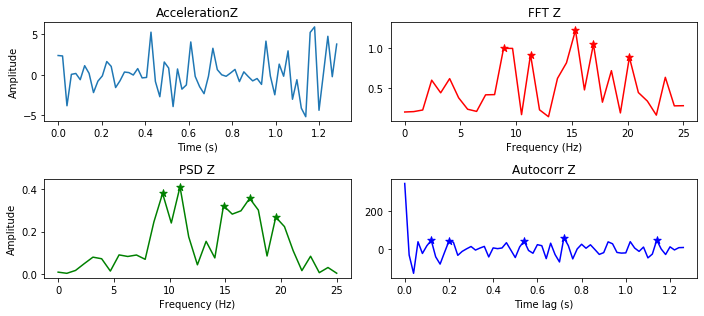

In [26]:
plt.figure(figsize=(10,4.5))
# plot 1
plt.subplot(221)
x_values, y_values = get_values(signal, N, f_s)
plt.plot(x_values, y_values)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('AccelerationZ')


# plot 2
plt.subplot(222)
x_values, y_values = get_fft_values(signal, N, f_s)
color = 'r'
plt.plot(x_values, y_values, c=color)
max_peak_height = 0.1 * np.nanmax(y_values)
indices_peaks = detect_peaks(y_values, mph=max_peak_height)
ans = np.argsort(y_values[indices_peaks])[-5:]
ans = indices_peaks[ans]
plt.scatter(x_values[ans],
            y_values[ans], c=color, marker='*', s=60)
plt.xlabel('Frequency (Hz)')
#plt.ylabel('Amplitude')
plt.title('FFT Z')

# plot 3
plt.subplot(223)
x_values, y_values = get_psd_values(signal, N, f_s)
color = 'g'
plt.plot(x_values, y_values, c=color)
max_peak_height = 0.1 * np.nanmax(y_values)
indices_peaks = detect_peaks(y_values, mph=max_peak_height)
ans = np.argsort(y_values[indices_peaks])[-5:]
ans = indices_peaks[ans]
plt.scatter(x_values[ans],
            y_values[ans], c=color, marker='*', s=60)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('PSD Z')

# plot 4
plt.subplot(224)
x_values, y_values = get_autocorr_values(signal, N, f_s)
color = 'b'
plt.plot(x_values, y_values, c=color)
max_peak_height = 0.1 * np.nanmax(y_values)
indices_peaks = detect_peaks(y_values, mph=max_peak_height)
ans = np.argsort(y_values[indices_peaks])[-5:]
ans = indices_peaks[ans]
plt.scatter(x_values[ans],
            y_values[ans], c=color, marker='*', s=60)
plt.xlabel('Time lag (s)')
#plt.ylabel('Amplitude')
plt.title('Autocorr Z')

plt.tight_layout()
plt.savefig('./frequencyDomain.svg', bbox_inches='tight', pad_inches=0)

## 小波域

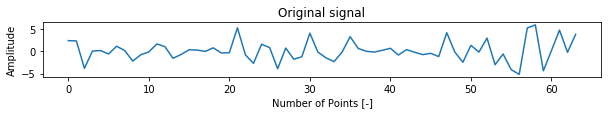

33
33
18
18
10
10


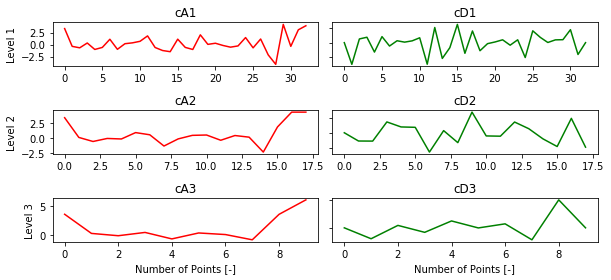

In [42]:
# 'rbio3.1'
# 'sym5'
# 'db6'
# 'db10'
# 'haar'


    
fig, ax = plt.subplots(figsize=(10,1))
ax.set_title("Original signal")
ax.plot(signal)
ax.set_xlabel('Number of Points [-]')
ax.set_ylabel('Amplitude')
plt.show()
fig.savefig('./wavelet1.svg', bbox_inches='tight', pad_inches=0)
    
data = signal
#waveletname = 'sym5'
waveletname = 'rbio3.1'
 
fig, axarr = plt.subplots(nrows=3, ncols=2, figsize=(8.5,4))
for ii in range(3):
    (data, coeff_d) = pywt.dwt(data, waveletname)
    print(len(data))
    print(len(coeff_d))
    axarr[ii, 0].plot(data, 'r')
    axarr[ii, 1].plot(coeff_d, 'g')
    axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), rotation=90)
    #axarr[ii, 0].set_yticklabels([])
    axarr[ii, 0].set_title('cA'+str(ii+1))
    axarr[ii, 1].set_title('cD'+str(ii+1))
    #if ii == 0:
    #    axarr[ii, 0].set_title("Approximation coefficients")
    #    axarr[ii, 1].set_title("Detail coefficients")
    axarr[ii, 1].set_yticklabels([])
    if(ii==2):
        axarr[ii, 0].set_xlabel('Number of Points [-]')
        axarr[ii, 1].set_xlabel('Number of Points [-]')
plt.tight_layout()
plt.show()
fig.savefig('./wavelet2.svg', bbox_inches='tight', pad_inches=0)



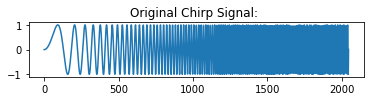

1025
1025
514
514
258
258
130
130
66
66


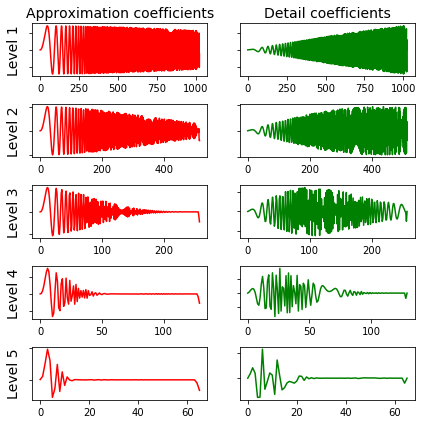

--------------------------------
66
66
130
258
514
1025


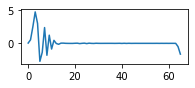

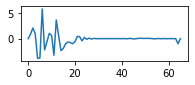

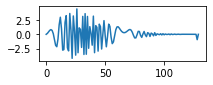

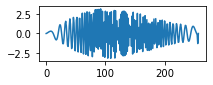

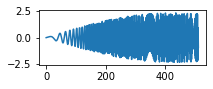

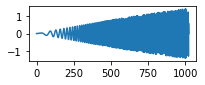

In [18]:
import pywt

x = np.linspace(0, 1, num=2048)
chirp_signal = np.sin(250 * np.pi * x**2)

fig, ax = plt.subplots(figsize=(6, 1))
ax.set_title("Original Chirp Signal: ")
ax.plot(chirp_signal)
plt.show()

data = chirp_signal
#waveletname = 'sym5'
waveletname = 'rbio3.1'

fig, axarr = plt.subplots(nrows=5, ncols=2, figsize=(6, 6))
for ii in range(5):
    (data, coeff_d) = pywt.dwt(data, waveletname)
    print(len(data))
    print(len(coeff_d))
    axarr[ii, 0].plot(data, 'r')
    axarr[ii, 1].plot(coeff_d, 'g')
    axarr[ii, 0].set_ylabel("Level {}".format(ii + 1),
                            fontsize=14, rotation=90)
    axarr[ii, 0].set_yticklabels([])
    if ii == 0:
        axarr[ii, 0].set_title("Approximation coefficients", fontsize=14)
        axarr[ii, 1].set_title("Detail coefficients", fontsize=14)
    axarr[ii, 1].set_yticklabels([])
plt.tight_layout()
plt.show()

print('--------------------------------')
list_coeff = pywt.wavedec(chirp_signal, waveletname, level=5)
for i in range(len(list_coeff)):
    print(len(list_coeff[i]))
    plt.figure(figsize=(3, 1))
    plt.plot(list_coeff[i])